# Synthetic Absorption Line Spectral Almanac (SALSA)

This notebook provides examples for working with the [SALSA catalogs of absorption spectra](https://www.tng-project.org/data/spectra/). We go through several possible use cases:

* Load a catalog of spectra, search based on equivalent width, and plot a single spectrum.
* Calculate statistics of absorption.
* Select a galaxy sample (from the subhalo catalog), then identify all close sightline pairs.
* Find the gas (cells) that contribute to the absorption in a spectrum, and load their properties from the snapshot.

You can either (i) use this notebook directory on the online TNG-Lab, or (ii) download the associated files and place them in the `{sim}/postprocessing/` directory.

# 1. Loading a catalog

In [44]:
import illustris_python as il
import matplotlib.pyplot as plt
import numpy as np
import glob
import h5py

In [45]:
# lets get a list of available files, print the first 20
basepath = '../sims.TNG/TNG50-1/'
specpath = basepath + 'postprocessing/AbsorptionSpectra/'

files = glob.glob(specpath + 'spectra*.hdf5')
for file in files[0:20]:
    print(file)

../sims.TNG/TNG50-1/postprocessing/AbsorptionSpectra/spectra_TNG50-1_z0.3_n1000d2-fullbox_SDSS-BOSS_NaI_combined.hdf5
../sims.TNG/TNG50-1/postprocessing/AbsorptionSpectra/spectra_TNG50-1_z4.0_n1000d2-fullbox_KECK-HIRES-B14_SiIV_combined.hdf5
../sims.TNG/TNG50-1/postprocessing/AbsorptionSpectra/spectra_TNG50-1_z3.0_n1000d2-fullbox_XSHOOTER-NIR-04_MgII_combined.hdf5
../sims.TNG/TNG50-1/postprocessing/AbsorptionSpectra/spectra_TNG50-1_z0.1_n1000d2-fullbox_COS-G130M_NV_combined.hdf5
../sims.TNG/TNG50-1/postprocessing/AbsorptionSpectra/spectra_TNG50-1_z0.1_n1000d2-fullbox_COS-G130M_NIII_combined.hdf5
../sims.TNG/TNG50-1/postprocessing/AbsorptionSpectra/spectra_TNG50-1_z1.5_n1000d2-fullbox_KECK-HIRES-B14_NV_combined.hdf5
../sims.TNG/TNG50-1/postprocessing/AbsorptionSpectra/spectra_TNG50-1_z0.3_n1000d2-fullbox_SDSS-BOSS_MgII_combined.hdf5
../sims.TNG/TNG50-1/postprocessing/AbsorptionSpectra/spectra_TNG50-1_z2.0_n1000d2-fullbox_SDSS-BOSS_MgII_combined.hdf5
../sims.TNG/TNG50-1/postprocessing/Ab

The naming structure is `spectra_{sim}_z{redshift}_{config}_{instrument}_{ion}_combined.hdf5`, where 

* `{config}` gives the configuration of the sightline number, direction, and position. For example, `n1000d2-fullbox` means $1000^2$ sightlines along the $\rm{d2}$ i.e. $\hat{z}$ direction, equally spaced across the full box. `n2000d2-rndfullbox` means $2000^2$ sightlines in the $\hat{z}$ direction, with random starting positions across the full box. Note that all sightlines traverse the simulation box exactly once, i.e. they are all $\rm{35 cMpc/h}$ long in the case of TNG50.
* `{instrument}` specifies the spectrograph that these spectra mimic, i.e. wavelength range and resolution (LSF).
* `{ion}` gives the species. Note that all (available) transitions are included in this same file.

Let's open one file at random and inspect its contents:

In [46]:
file = specpath + 'spectra_TNG50-1_z0.7_n1000d2-fullbox_DESI_MgII_combined.hdf5'

print(file)
with h5py.File(file, 'r') as f:
    for key in f:
        print(key, f[key].shape)

../sims.TNG/TNG50-1/postprocessing/AbsorptionSpectra/spectra_TNG50-1_z0.7_n1000d2-fullbox_DESI_MgII_combined.hdf5
EW_MgII_2796 (1000000,)
EW_MgII_2803 (1000000,)
flux (1000000, 7780)
ray_dir (3,)
ray_pos (1000000, 3)
ray_total_dl ()
tau_MgII_2796 (1000000, 7780)
tau_MgII_2803 (1000000, 7780)
wave (7780,)


This catalog for **MgII** contains two transitions: 2796 and 2803 (Ang).

See the [SALSA documentation](https://www.tng-project.org/data/spectra/#spec) for a complete description of all these datasets.

## Load EWs and search based on EW

In [47]:
with h5py.File(file, 'r') as f:
    EW = f['EW_MgII_2796'][()]

inds_strong = np.where(EW > 0.3)[0]
print('[%d of %d] spectra have EW > 0.3 Ang.' % (inds_strong.size, EW.size))

[14601 of 1000000] spectra have EW > 0.3 Ang.


## Load a single random spectrum and plot

In [5]:
ind = inds_strong[0]

with h5py.File(file, 'r') as f:
    wave = f['wave'][()]
    flux = f['flux'][ind,:]

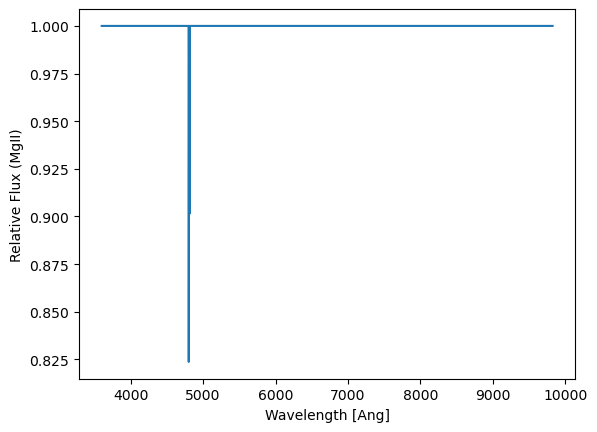

In [6]:
fig, ax = plt.subplots()
ax.set_xlabel('Wavelength [Ang]')
ax.set_ylabel('Relative Flux (MgII)')
ax.plot(wave, flux);

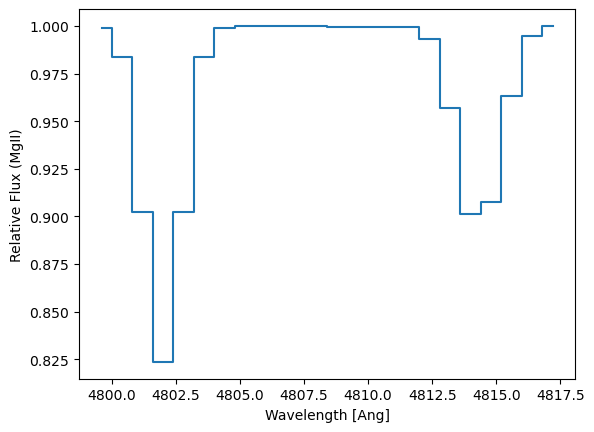

In [7]:
# zoom in to the feature of interest
w = np.where(flux < 1.0)

fig, ax = plt.subplots()
ax.set_xlabel('Wavelength [Ang]')
ax.set_ylabel('Relative Flux (MgII)')
ax.step(wave[w], flux[w], where='mid');

Note: the `flux` dataset contains all transitions. If you want to isolate the absorption due to a particular line, i.e. just the 2796 component of the MgII doublet, you can load the `tau` dataset and transform it to flux as $f = \exp(-\tau)$.

In [8]:
with h5py.File(file, 'r') as f:
    tau_2796 = f['tau_MgII_2796'][ind,:]

In [9]:
flux_2796 = np.exp(-tau_2796)

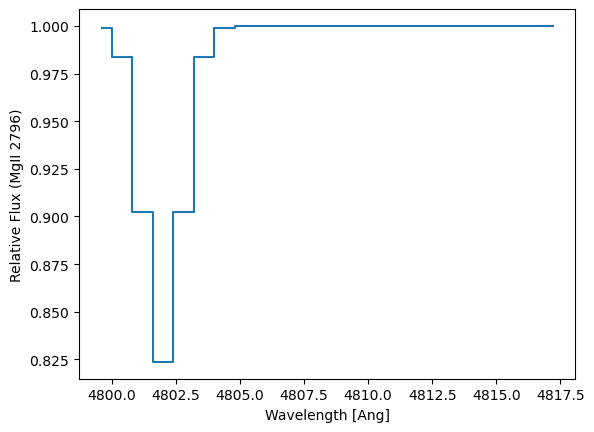

In [10]:
fig, ax = plt.subplots()
ax.set_xlabel('Wavelength [Ang]')
ax.set_ylabel('Relative Flux (MgII 2796)')
ax.step(wave[w], flux_2796[w], where='mid');

# 2. Load EWs and calculate 'blind' absorber statistics

In [11]:
with h5py.File(file, 'r') as f:
    EW = f['EW_MgII_2796'][()]
    redshift = f.attrs['redshift']
    count = EW.size

# convert to rest-frame EW
EW /= (1+redshift)

# mimic some observational detection threshold
EW_min = 0.01 # Ang

EW = EW[EW > EW_min]

In [12]:
# use astropy to calculate a dz corresponding to the TNG50 box-length at this redshift
import astropy.units as u
from astropy.cosmology import Planck15, z_at_value
dist = Planck15.comoving_distance(redshift)

header = il.groupcat.loadHeader(basepath + 'output/', 0)
box_length = header['BoxSize'] / 1000 / header['HubbleParam'] # cMpc
dist += box_length * u.Mpc

# use z_at_value() helper to find the redshift where the comoving distance has increase by one box-length
z_final = z_at_value(Planck15.comoving_distance,dist)
dz = z_final - redshift

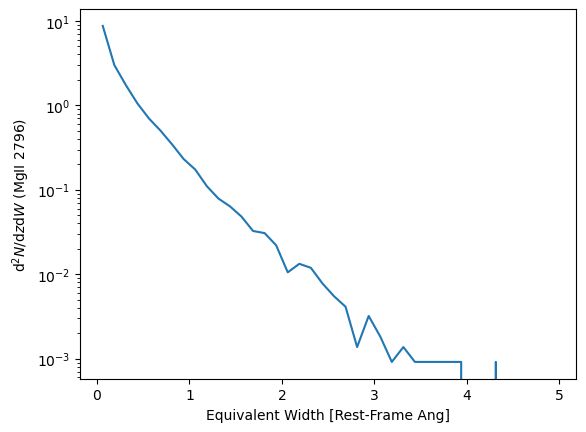

In [13]:
# calculate the incidence d/dWdz i.e. normalized by the redshift path length dz and per unit EW
hh, bin_edges = np.histogram(EW, bins=40, range=[0,5.0])
bin_cen = (bin_edges[1:] + bin_edges[:-1])/2

dW_norm = bin_edges[1:] - bin_edges[:-1] # constant (linear)

hh_norm = hh / (count * dz * dW_norm)

# plot
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.set_xlabel('Equivalent Width [Rest-Frame Ang]')
ax.set_ylabel('d$^2 N$/d$z$d$W$ (MgII 2796)')
ax.plot(bin_cen, hh_norm);

# 3. Selecting a galaxy sample

Next, we will consider an absorber-galaxy connection type analysis, where we are interested in absorption occuring near galaxies.

As a first step, we will select a galaxy sample of interest. This could be based on any properties available in the simulation, but here we will simply take a bin of $10.3 < \log(M_\star / \rm{M}_\odot) < 10.4$ as an example.

In [14]:
def redshift_to_snapnum(basepath, redshift):
    num_snaps = len(glob.glob(basepath + 'snapdir*'))
    redshifts = np.zeros(num_snaps, dtype='float32')

    for snap in range(redshifts.size):
        header = il.groupcat.loadHeader(basepath, snap)
        redshifts[snap] = header['Redshift']

    diff = np.abs(redshifts - redshift)
    snap = np.where(diff == diff.min())[0][0]
    return snap

# find the snapshot number of the redshift of this spectra file
snapnum = redshift_to_snapnum(basepath + 'output/', redshift=redshift)

In [15]:
subhalos = il.groupcat.loadSubhalos(basepath+'output/', snapnum, ['SubhaloPos','SubhaloMassInRadType'])

In [16]:
mstar = np.log10(subhalos['SubhaloMassInRadType'][:,4] * 1e10 / 0.6774)

/tmp/ipykernel_219/464491474.py:1: RuntimeWarning: divide by zero encountered in log10
  mstar = np.log10(subhalos['SubhaloMassInRadType'][:,4] * 1e10 / 0.6774)


In [17]:
subhalo_inds = np.where((mstar>10.3) & (mstar<=10.4))[0]
print('Selected [%d of %d] subhalos.' % (subhalo_inds.size, subhalos['count']))

Selected [74 of 6459496] subhalos.


## Load and plot the positions of all sightlines

In [48]:
# load the sightline positions
with h5py.File(file, 'r') as f:
    ray_pos = f['ray_pos'][()]
    ray_dir = f['ray_dir'][()]

# reduce 3D ray starting positions to the 2D positions i.e. analogous to (ra,dec) on the plane of the sky
dir_ind = np.where(ray_dir == 1)[0][0]
sky_inds = list(set([0,1,2]) - set([dir_ind])) # e.g. [0,1] for projAxis == 2

ray_pos = ray_pos[:,sky_inds]

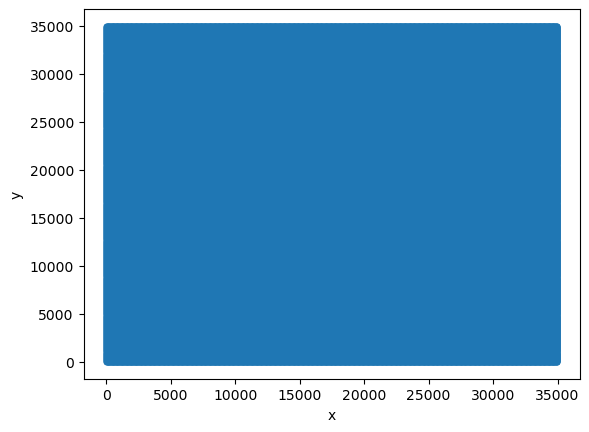

In [49]:
# plot the sightline positions for fun
fig, ax = plt.subplots()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.scatter(ray_pos[:,0], ray_pos[:,1], marker='.');

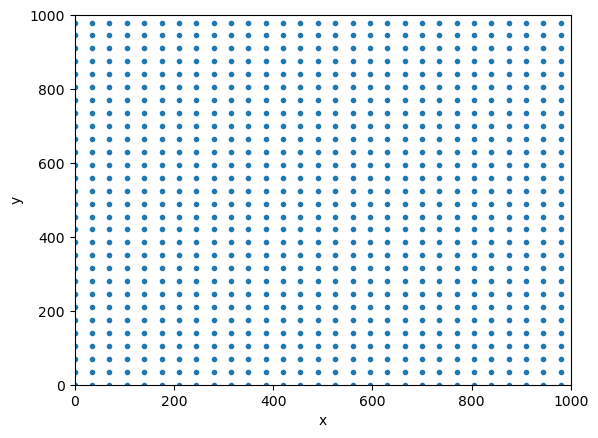

In [50]:
# they fill the full TNG50 box (35000 ckpc/h), as expected
# zoom in on a smaller region to look at the actual distribution - in this case, it is uniform i.e. the sightlines make a Cartesian grid
fig, ax = plt.subplots()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim([0, 1000])
ax.set_ylim([0, 1000])
ax.scatter(ray_pos[:,0], ray_pos[:,1], marker='.');

/tmp/ipykernel_219/349997934.py:10: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(grid), extent=extent, cmap='magma')


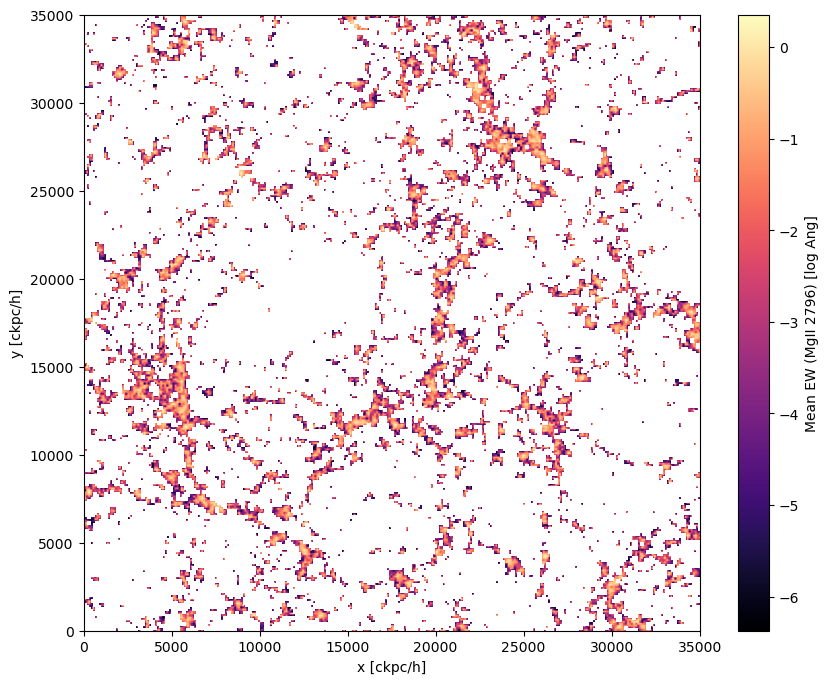

In [68]:
# we can also plot a 'picture' of absorption strength across the simulation, using EW to set color
from scipy.stats import binned_statistic_2d

minMax = [0, header['BoxSize']]
grid, _, _, _ = binned_statistic_2d(ray_pos[:,0], ray_pos[:,1], EW, 'mean', bins=[300,300], range=[minMax,minMax])

fig, ax = plt.subplots(figsize=(10,8))

extent = [0, header['BoxSize'], 0, header['BoxSize']]
plt.imshow(np.log10(grid), extent=extent, cmap='magma')
ax.autoscale(False)
ax.set_xlabel('x [ckpc/h]')
ax.set_ylabel('y [ckpc/h]')
plt.colorbar(label='Mean EW (MgII 2796) [log Ang]');

## Find the sightlines that are near galaxies

We will search for any sightlines that pass within a projected distance (i.e. impact parameter) of 100 kpc of any galaxy in our sample.

In [21]:
# helper function: 2d distances, accounting for the periodic boundaries
def dists_2d_periodic(pt, vecs, boxsize):
    x_dist = vecs[:,0] - pt[0]
    y_dist = vecs[:,1] - pt[1]

    x_dist[x_dist > boxsize*0.5] -= boxsize
    x_dist[x_dist <= -boxsize*0.5] += boxsize
    y_dist[y_dist > boxsize*0.5] -= boxsize
    y_dist[y_dist <= -boxsize*0.5] += boxsize

    return np.sqrt(x_dist**2 + y_dist**2)

In [22]:
# find all sightlines that pass within D_max of a galaxy
D_max = 100.0
ray_inds = np.zeros(0, dtype='int32')
ray_dists = np.zeros(0, dtype='float32')

for i, subhalo_ind in enumerate(subhalo_inds):
    # (x,y) i.e. ~(ra,dec) position of this galaxy
    subhalo_pos = subhalos['SubhaloPos'][subhalo_ind, sky_inds]

    # calculate distance from this galaxy to all sightlines
    dists = dists_2d_periodic(subhalo_pos, ray_pos, header['BoxSize'])

    # convert code length units (ckpc/h) to pkpc
    scalefac = 1 / (1+redshift)
    dists *= scalefac/header['HubbleParam']

    # search
    ray_inds_local = np.where(dists <= D_max)[0]
    print(i, subhalo_ind, ray_inds_local.size)

    ray_inds = np.hstack((ray_inds, ray_inds_local))
    ray_dists = np.hstack((ray_dists, dists[ray_inds_local]))
    
print('In total have [%d] sightlines within [%.1f] pkpc.' % (ray_inds.size, D_max))

0 9 32
1 11 35
2 32350 35
3 48197 34
4 48201 34
5 48202 35
6 69767 34
7 69768 34
8 95231 33
9 128026 35
10 138901 35
11 147941 34
12 158825 32
13 172233 34
14 181445 32
15 217468 32
16 232105 34
17 249725 33
18 249728 35
19 255494 36
20 262485 34
21 262486 32
22 265332 32
23 269041 32
24 294336 34
25 294337 34
26 302037 34
27 303110 35
28 306477 33
29 329128 34
30 335148 35
31 339442 35
32 342523 32
33 349073 34
34 351063 32
35 352701 34
36 361320 34
37 362173 32
38 362907 33
39 366255 34
40 367116 33
41 368188 34
42 371466 34
43 373072 35
44 373431 34
45 375106 33
46 378432 32
47 379450 35
48 381112 32
49 382236 32
50 388843 35
51 389982 34
52 390308 32
53 391531 34
54 391944 37
55 392839 34
56 393453 35
57 393732 34
58 396330 34
59 398013 34
60 398282 35
61 398592 35
62 406096 34
63 406347 35
64 407207 32
65 407428 34
66 409926 35
67 414842 34
68 415508 35
69 417238 32
70 418144 34
71 420173 34
72 428453 35
73 434085 32
In total have [2500] sightlines within [100.0] pkpc.


## Plot EW as a function of impact parameter

In [23]:
with h5py.File(file, 'r') as f:
    EW = f['EW_MgII_2796'][()]

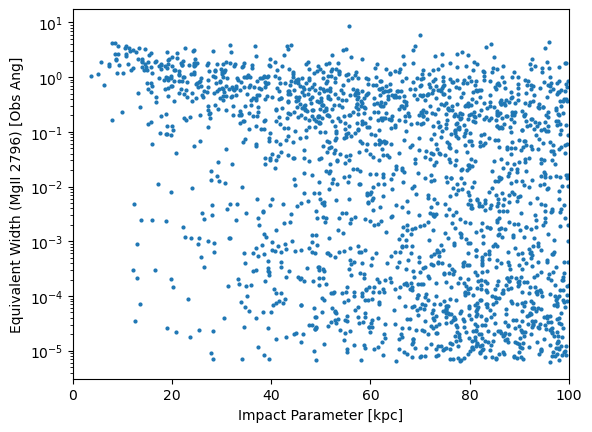

In [29]:
fig, ax = plt.subplots()
ax.set_xlim([0, D_max])
ax.set_yscale('log')
ax.set_xlabel('Impact Parameter [kpc]')
ax.set_ylabel('Equivalent Width (MgII 2796) [Obs Ang]')
ax.scatter(ray_dists, EW[ray_inds], marker='o', s=4);

Note: we have not applied any velocity window ($\pm \Delta v$) cut in this analysis. Some of the MgII absorbers are undoubtedly rather far, along the line-of-sight direction, from these galaxies. A more careful analysis, i.e. to compare to data, could calculate a $z_{\rm eff} = (1 + z_{\rm doppler})(1 + z_{\rm cosmo}) - 1$ for each galaxy and only include galaxy-absorber pairs sufficiently close in redshift. In this case, $z_{\rm doppler} = v_{\rm LOS} / c$ where $v_{\rm LOS}$ is the peculiar velocity of the galaxy along the line-of-sight (`SubhaloVel[2]` is a reasonable approximation), and $z_{\rm cosmo}$ is the snapshot redshift plus the comoving distance from the front of the box (i.e. start of the ray) to this galaxy, converted to a $dz$.

# 4. Identify the gas cells that produce absorption in a spectrum

In [30]:
# parse the spectra filename for details
file = specpath + 'spectra_TNG50-1_z0.7_n1000d2-fullbox_DESI_MgII_combined.hdf5'
_, sim, redshift_str, config, instrument, ion, _ = file.split("/")[-1].split("_")
config = "_".join(config.split("-")[::-1]) # naming convention

print(sim, redshift_str, config, instrument, ion)

# choose one from random that we have been considering
ray_index = ray_inds[10]

print(ray_index, EW[ray_index])

TNG50-1 z0.7 fullbox_n1000d2 DESI MgII
180677 0.5704364


## First, load the corresponding sightline.

In [31]:
# load the corresponding sightline file
N_chunks = 16

def spec_index_to_filenum(index, rays_per_file):
    """ Return the file chunk number, and local index, for the global spectrum index. """
    offset = 0

    for i in range(N_chunks):
        if index < offset + rays_per_file:
            break
        offset += rays_per_file

    local_index = index - offset
    return i, local_index

In [32]:
sightline_path = basepath + 'postprocessing/AbsorptionSightlines/'

# load first chunk for metadata
sightline_file = f'voronoi_{config}_{snapnum:03d}-split-0-{N_chunks}.hdf5'

with h5py.File(sightline_path + sightline_file, 'r') as f:
    rays_per_file = f['rays_len'].size

In [33]:
# which file is our sightline index in?
file_num, local_index = spec_index_to_filenum(ray_index, rays_per_file)

sightline_file = f'voronoi_{config}_{snapnum:03d}-split-{file_num}-{N_chunks}.hdf5'

# load
with h5py.File(sightline_path + sightline_file, 'r') as f:
    ray_len = f['rays_len'][local_index]
    ray_offset = f['rays_off'][local_index]

    # pathlengths through each gas cell
    ray_dl = f['rays_dl'][ray_offset:ray_offset+ray_len]
    
    # these index f['cell_inds']
    ray_inds = f['rays_inds'][ray_offset:ray_offset+ray_len]

    # two choices:
    print('Loading...')
    if 1:
        # global load, then subset (faster if ray_inds is large)
        cell_inds = f['cell_inds'][()][ray_inds]
    else:
        # load index by index (faster if ray_inds is small)
        cell_inds = np.zeros(ray_inds.size, dtype='int64')
        for i in range(ray_inds):
            cell_inds[i] = f['cell_inds'][ray_inds[i]]

print('Done.')

Loading...
Done.


In [34]:
print('Total number of gas cells this sightline intersects: ', cell_inds.size)
print('Total pathlength: ', ray_dl.sum()) # should equal the simulation box-length

Total number of gas cells this sightline intersects:  3489
Total pathlength:  35000.0


## Then, we can load gas cell properties from the simulation snapshot itself.

Important note: the `cell_inds` we have obtained are global indices into the simulation snapshot (for this PartType).

In [43]:
# helper functions for chunked load of a set of indices from a snapshot
def pSplitRange(indrange, numProcs, curProc):
    """ Divide work. Input: a 2-tuple of [start,end] indices. Return: a new range subset.
    If inclusive==True, then assume the range subset will be used e.g. as input to snapshotSubseet(),
    which unlike numpy convention is inclusive in the indices."""
    assert len(indrange) == 2 and indrange[1] > indrange[0]

    if numProcs == 1:
        if curProc != 0:
            raise Exception("Only a single processor but requested curProc>0.")
        return indrange

    # split array into numProcs segments, and return the curProc'th segment
    splitSize = int(np.floor( (indrange[1]-indrange[0]) / numProcs ))
    start = indrange[0] + curProc*splitSize
    end   = indrange[0] + (curProc+1)*splitSize

    # for last split, make sure it takes any leftovers
    if curProc == numProcs-1:
        end = indrange[1]

    return [start,end]
    
def snapshotSubsetLoadIndicesChunked(basepath, snapnum, partType, field, inds, nChunks=20):
    """ If we only want to load a set of inds, and this is a small fraction of the
    total snapshot, then we do not ever need to do a global load or allocation, thus
    reducing the peak memory usage during load by a factor of nChunks or
    sP.numPart[partType]/inds.size, whichever is smaller. Note: currently only for
    a single field, could be generalized to multiple fields. """
    ptNum = il.util.partTypeNum(partType)

    with h5py.File(il.snapshot.snapPath(basepath,snapnum), 'r') as f:
        header = dict(f['Header'].attrs.items())
    numPartTot = il.snapshot.getNumPart(header)[ptNum]

    subset = il.snapshot.getSnapOffsets(basepath, snapnum, 0, "Subhalo")

    ind_frac = inds.size / numPartTot * 100
    print('Loading [%s, %s], indices cover %.3f%% of snapshot total.' % (partType,field,ind_frac))

    # get shape and dtype by loading one element
    subset['lenType'][ptNum] = 1
    sample = il.snapshot.loadSubset(basepath, snapnum, partType, fields=[field], subset=subset, sq=False)
    
    fieldName = list(sample.keys())[-1]
    assert fieldName != 'count' # check order guarantee

    sample = sample[fieldName]

    shape = [inds.size] if sample.ndim == 1 else [inds.size,sample.shape[1]] # [N] or e.g. [N,3]

    # allocate
    data = np.zeros(shape, dtype=sample.dtype)

    # sort requested indices, to ease intersection with each indRange_loc
    sort_inds = np.argsort(inds)
    sorted_inds = inds[sort_inds]

    # chunk load
    for i in range(nChunks):
        print(' %d%%' % (float(i)/nChunks*100), end='', flush=True)

        indRange_loc = pSplitRange([0,numPartTot-1], nChunks, i)

        if indRange_loc[0] > sorted_inds.max() or indRange_loc[1] < sorted_inds.min():
            continue

        # which of the input indices are covered by this local indRange?
        ind0 = np.searchsorted(sorted_inds, indRange_loc[0], side='left')
        ind1 = np.searchsorted(sorted_inds, indRange_loc[1], side='right')

        if ind0 == ind1:
            continue

        # load subset
        #data_loc = sP.snapshotSubsetP(partType, field, indRange=indRange_loc)
        subset['offsetType'][ptNum] = indRange_loc[0]
        subset['lenType'][ptNum] = indRange_loc[1] - indRange_loc[0]
        data_loc = il.snapshot.loadSubset(basepath, snapnum, partType, fields=[field], subset=subset, sq=True)

        # sort_inds[ind0:ind1] gives us which inds are in this data_loc
        # the entires in data_loc are sorted_inds[ind0:ind1]-indRange_loc[0]
        stamp_inds = sort_inds[ind0:ind1]
        take_inds = sorted_inds[ind0:ind1] - indRange_loc[0]

        data[stamp_inds] = data_loc[take_inds]

    return data

We can use the above helper function to load a small set of indices from the simulation snapshot in a "chunked" manner, such that only a small fraction of the (very large) TNG50-1 snapshot is ever loaded. This prevents the Lab, and/or your computer, from running out of memory. Note: if you are analyzing a large number of spectra in this way, it will be more efficient to simply load (one field of) the entire snapshot, then index it as an in-memory numpy array.

In [36]:
# load gas density as an example
partType = 'gas'
field = 'Density'

dens = snapshotSubsetLoadIndicesChunked(basepath+'output/', snapnum, partType, field, cell_inds)

Loading [gas, Density], indices cover 0.000% of snapshot total.
 0% 5% 10% 15% 20% 25% 30% 35% 40% 45% 50% 55% 60% 65% 70% 75% 80% 85% 90% 95%

In [37]:
# unit conversions [code density -> physical cm^-3]
scalefac = 1 / (1+redshift)
UnitDensity_in_cgs = 6.7699e-22 # given standard TNG unit system
mass_proton = 1.672622e-24 # cgs

dens_cgs = dens * header['HubbleParam']**2 / scalefac**3 * UnitDensity_in_cgs / mass_proton
dens_cgs = np.log10(dens_cgs)

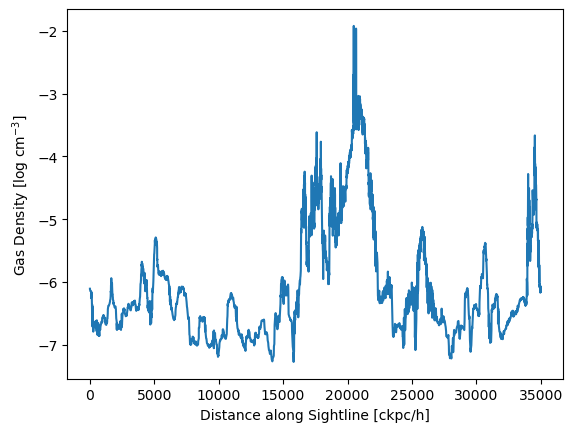

In [38]:
# plot
dl_cumulative = np.cumsum(ray_dl) # code units

fig, ax = plt.subplots()
ax.set_xlabel('Distance along Sightline [ckpc/h]')
ax.set_ylabel('Gas Density [log cm$^{-3}$]')

ax.plot(dl_cumulative, dens_cgs);

All other physical properties of gas, such as temperature, metallicity, line-of-sight velocity, and so on, are also available in this way.

Note: one may also want to identify the particular cells that contribute to a specific absorption feature, defined as spanning a given wavelength range. In this case, the approach would be the same as the galaxy-absorber note above. In particular, for each intersected gas cell, one can calculate $1 + z_{\rm eff} = (1 + z_{\rm doppler})(1 + z_{\rm cosmo})$ using its line-of-sight velocity and distance from the start of the ray. Then $\lambda_{\rm obs} = \lambda_0 (1 + z_{\rm eff})$ gives the center of its optical depth contribution to the spectrum. All of the cells contributing (non-negligibly) to an absorber can be identified in this way.

## Questions, Suggestions?

If you have any other questions or ideas on how to expand these examples, please contact Dylan Nelson.